## In the notebook, true_freshwater_fluxes.ipynb, we showed the way of quantifying true fluxes that projects the fluxes onto the FAFMIP perturbation. There are a few other options shown here

In [13]:
import scipy.io
import netCDF4
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, glob 
import imageio
from matplotlib import animation
import copy
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter #see https://scitools.org.uk/cartopy/docs/v0.15/examples/tick_labels.html
import certifi
import ssl
import math
ssl._create_default_https_context = ssl._create_unverified_context
from scipy import stats
from xgcm import Grid
import statsmodels.api as sm
import matplotlib.ticker as ticker
from matplotlib.axes._secondary_axes import SecondaryAxis
import xesmf as xe

In [14]:
#First, load in all the freshwater fluxes. See notebook processing_salt_fluxes.py for how to generate this files that we unpickle here
#The location of these files is where ever the user placed them after running processing_salt_fluxes.py

import pickle

with open("/scratch/abf376/regridded_salt_flux_historical", "rb") as fp:   #Unpickling, replace string with drectory where pickled file lives
    regridded=pickle.load(fp)

with open("/scratch/abf376/regridded_salt_flux_2005on", "rb") as fp:   #Unpickling
    regridded_2005on=pickle.load(fp)

In [15]:
#As in true_freshwater_fluxes.ipynb, we get the ensemble mean 

#average over ensemble member
salt_flux_avg_pre2005=sum(regridded)/34
salt_flux_avg_pre2005=salt_flux_avg_pre2005.rename({'y': 'latitude','x': 'longitude'})
salt_flux_avg_pre2005=salt_flux_avg_pre2005.assign_coords(latitude=salt_flux_avg_pre2005.lat[:,0],longitude=salt_flux_avg_pre2005.lon[0,:])

salt_flux_avg_2005on=sum(regridded_2005on)/34
salt_flux_avg_2005on=salt_flux_avg_2005on.rename({'y': 'latitude','x': 'longitude'})
salt_flux_avg_2005on=salt_flux_avg_2005on.assign_coords(latitude=salt_flux_avg_2005on.lat[:,0],longitude=salt_flux_avg_2005on.lon[0,:])

salt_avg=xr.concat([salt_flux_avg_pre2005,salt_flux_avg_2005on],dim="time") #concatenate so now this is from 1920 to 2080
salt_flux_avg_1970to2019=salt_avg[12*50:12*100,:,:] #salt_avg was from 1920 to 2080 so this is from 1970 to 2019

climatological_salt_flux=salt_avg[0:12*55,:,:].mean('time') #this is 1920 to 1975

In [16]:
#create area grid

import sys
sys.path.insert(1, '/scratch/abf376/')
from area_grid import *

area=area_grid(latitudes=np.array(salt_flux_avg_pre2005[0,:,:].latitude),longitudes=salt_flux_avg_pre2005[0,:,:].longitude)
area=xr.DataArray(area,dims=["latitude","longitude"],coords=[salt_flux_avg_pre2005[0,:,:].latitude,salt_flux_avg_pre2005[0,:,:].longitude])

In [17]:
#water flux from fafmip
f='/scratch/abf376/FAFMIP_wfo_v2.nc' #this is the first 50 years
file2read = netCDF4.Dataset(f,'r')
#print(file2read.variables)
wfo = xr.open_dataset(f)['water_flux_into_sea_water']
wfo=wfo.where(wfo<1E19)


area_wfo=area_grid(latitudes=np.array(wfo.latitude),longitudes=wfo.longitude)
area_wfo=xr.DataArray(area,dims=["latitude","longitude"],coords=[wfo.latitude,wfo.longitude])

In [14]:
((np.abs(wfo.mean('time')))*area_wfo.where(area_wfo.latitude<65)).sum()

<xarray.DataArray ()>
array(1.08156723e+09)

In [18]:
#regrid wfo
ds_out = xe.util.grid_global(1, 1)
regridder_wfo= xe.Regridder(wfo, ds_out, "bilinear",periodic=True)
wfo = regridder_wfo(wfo)
wfo=wfo.rename({'y': 'latitude','x': 'longitude'})
wfo=wfo.assign_coords(latitude=wfo.lat[:,0],longitude=wfo.lon[0,:])

/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [19]:
# a list of all ensemble members
for i in range(0,34):
    regridded[i]=regridded[i].rename({'y': 'latitude','x': 'longitude'})
    regridded[i]=regridded[i].assign_coords(latitude=salt_flux_avg_pre2005.latitude,longitude=salt_flux_avg_pre2005.longitude)
    
    regridded_2005on[i]=regridded_2005on[i].rename({'y': 'latitude','x': 'longitude'})
    regridded_2005on[i]=regridded_2005on[i].assign_coords(latitude=salt_flux_avg_pre2005.latitude,longitude=salt_flux_avg_pre2005.longitude)
    
salt_avg_list=[]
for i in range(0,34):
    salt_avg_list.append(xr.concat([regridded[i],regridded_2005on[i]],dim="time"))
    
climatological_salt_flux_list=[]
for i in range(0,34):
    climatological_salt_flux_list.append(salt_avg_list[i][0:12*55,:,:].mean('time')) #this is 1920 to 1975
    salt_avg_list[i]=salt_avg_list[i][12*50:12*100,:,:]

### Method 1:
Naively just looking at strength in the pattern, without accounting for how it correlates with the FAFMIP pattern

In [20]:
change_EP=np.empty(50)
change_EP_timesarea=np.empty(50)
for i in range(0,50):
    change_EP[i]=(np.abs(salt_flux_avg_1970to2019[i*12:(i+1)*12,:,:].mean('time')-salt_flux_avg_1970to2019[0*12:10*12,:,:].mean('time'))*area.where(area.latitude<65)).sum()/(area.where(area.latitude<65)).sum()
    change_EP_timesarea[i]=(np.abs(salt_flux_avg_1970to2019[i*12:(i+1)*12,:,:].mean('time')-salt_flux_avg_1970to2019[0*12:10*12,:,:].mean('time'))*area.where(area.latitude<65)).sum()

In [21]:
#same but for list
change_EP_timesarea_list=np.empty([34,50])
for j in range(0,34):
    #print(j)
    for i in range(0,50):
        change_EP_timesarea_list[j,i]=(np.abs(salt_avg_list[j][i*12:(i+1)*12,:,:].mean('time')-climatological_salt_flux_list[j])*area.where(area.latitude<65)).sum()

In [22]:
np.random.seed(0)
A=((np.abs(wfo.mean('time')))*area.where(area.latitude<65)).sum() #strength of wfo in this way, 9.99660706e+08 if calculated with regridded or 1.08156723e+09 if not calculated with regridded

change1=np.empty([500])
trend=np.empty([45])
p=scipy.stats.linregress(np.linspace(0,44,45), y=change_EP_timesarea[5:50], alternative='two-sided')
trend=p.intercept+p.slope*np.linspace(0,44,45)

from recombinator.block_bootstrap import circular_block_bootstrap

# number of replications for bootstraps (number of resampled time-series to generate)
B = 500

y_star_cb \
    = circular_block_bootstrap(change_EP_timesarea[5:50]-trend, 
                               block_length=2, 
                               replications=B, replace=True)
bootstrap=[]
for i in range(0,B):
    bootstrap.append(trend+y_star_cb[i,:])

for i in range(0,B):
    change1[i]=(bootstrap[i][42:45].mean()-bootstrap[i][0:3].mean())/A

print(change1.mean())
print(change1.std())

0.3550123244043945
0.07813621049214563


In [23]:
np.random.seed(0)

change=np.empty([3000,34])
for j in range(0,34):
    trend=np.empty([45])
    p=scipy.stats.linregress(np.linspace(0,44,45), y=change_EP_timesarea_list[j,5:50], alternative='two-sided')
    trend=p.intercept+p.slope*np.linspace(0,44,45)

    from recombinator.block_bootstrap import circular_block_bootstrap

    # number of replications for bootstraps (number of resampled time-series to generate)
    B = 3000

    y_star_cb \
        = circular_block_bootstrap(change_EP_timesarea_list[j,5:50]-trend, 
                                   block_length=3, 
                                   replications=B, replace=True)
    bootstrap=[]
    for i in range(0,B):
        bootstrap.append(trend+y_star_cb[i,:])

    for i in range(0,B):
        change[i,j]=(bootstrap[i][42:45].mean()-bootstrap[i][0:3].mean())/A

mean_boot_m1=np.empty([34])
std_boot_m1=np.empty([34])
for j in range(0,34):
    mean_boot_m1[j]=change[:,j].mean()
    std_boot_m1[j]=change[:,j].std()

### Method 2:
Integrating the change in the strength of the pattern and making it follow the large scale features of the FAFMIP perturbation - i.e. integrating over where wfo is positive and negative separately and summing.

Note this was method 3 in the not cleaned up notebook actual_change_fixed_v2.ipynb

In [24]:
EP_pattern_wfo=np.empty(50)
for i in range(0,50):
    EP_pattern_wfo[i]=np.abs((((salt_flux_avg_1970to2019[i*12:(i+1)*12,:,:].mean('time')).where(np.sign(wfo.mean('time'))>0))*area.where(area.latitude<65)).sum())+np.abs((((salt_flux_avg_1970to2019[i*12:(i+1)*12,:,:].mean('time')).where(np.sign(wfo.mean('time'))<0))*area.where(area.latitude<65)).sum())

In [28]:
np.random.seed(0)
A=((np.abs(wfo.mean('time')))*area.where(area.latitude<65)).sum() #strength of wfo in this way, 9.99660706e+08 if calculated with regridded or 1.08156723e+09 if not calculated with regridded


change2=np.empty([500])
trend=np.empty([45])
p=scipy.stats.linregress(np.linspace(0,44,45), y=EP_pattern_wfo[5:50], alternative='two-sided')
trend=p.intercept+p.slope*np.linspace(0,44,45)

from recombinator.block_bootstrap import circular_block_bootstrap

# number of replications for bootstraps (number of resampled time-series to generate)
B = 500

y_star_cb \
    = circular_block_bootstrap(EP_pattern_wfo[5:50]-trend, 
                               block_length=2, 
                               replications=B, replace=True)
bootstrap=[]
for i in range(0,B):
    bootstrap.append(trend+y_star_cb[i,:])

for i in range(0,B):
    change2[i]=(bootstrap[i][42:45].mean()-bootstrap[i][0:3].mean())/A

print(change2.mean())
print(change2.std())

0.38961560370876636
0.06662473381655681


In [10]:
EP_pattern_wfo_list=np.empty([34,50])
for j in range(0,34):
    for i in range(0,50):
        EP_pattern_wfo_list[j,i]=np.abs((((salt_avg_list[j][i*12:(i+1)*12,:,:].mean('time')).where(np.sign(wfo.mean('time'))>0))*area.where(area.latitude<65)).sum())+np.abs((((salt_avg_list[j][i*12:(i+1)*12,:,:].mean('time')).where(np.sign(wfo.mean('time'))<0))*area.where(area.latitude<65)).sum())

In [29]:
pval_store=np.empty(34)
np.random.seed(0)
A=((np.abs(wfo.mean('time')))*area.where(area.latitude<65)).sum() #strength of wfo in this way, 9.99660706e+08 if calculated with regridded or 1.08156723e+09 if not calculated with regridded

change=np.empty([3000,34])
for j in range(0,34):
    trend=np.empty([45])
    p=scipy.stats.linregress(np.linspace(0,44,45), y=EP_pattern_wfo_list[j,5:50], alternative='two-sided')
    trend=p.intercept+p.slope*np.linspace(0,44,45)
    pval_store[j]=p.pvalue

    from recombinator.block_bootstrap import circular_block_bootstrap

    # number of replications for bootstraps (number of resampled time-series to generate)
    B = 3000

    y_star_cb \
        = circular_block_bootstrap(EP_pattern_wfo_list[j,5:50]-trend, 
                                   block_length=3, 
                                   replications=B, replace=True)
    bootstrap=[]
    for i in range(0,B):
        bootstrap.append(trend+y_star_cb[i,:])

    for i in range(0,B):
        change[i,j]=(bootstrap[i][42:45].mean()-bootstrap[i][0:3].mean())/A

mean_boot_m2=np.empty([34])
std_boot_m2=np.empty([34])
for j in range(0,34):
    mean_boot_m2[j]=change[:,j].mean()
    std_boot_m2[j]=change[:,j].std()

In [30]:
import pickle
with open("freshwater_fluxes_integration_mean_boot", "wb") as fp:   #Pickling
    pickle.dump(mean_boot_m2, fp)
with open("freshwater_fluxes_integration_std_boot", "wb") as fp:   #Pickling
    pickle.dump(std_boot_m2, fp)
with open("freshwater_fluxes_integration_pval_lin_regress", "wb") as fp:   #Pickling
    pickle.dump(pval_store, fp)

ensemble_projection_mean_std=[change2.mean(),change2.std()]
with open("freshwater_fluxes_ensemble_integration_mean_std", "wb") as fp:   #Pickling
    pickle.dump(ensemble_projection_mean_std, fp)

These give quite different results. Let's load in the true changes in freshwater fluxes from the method we chose - the change in the projection onto the FAFMIP pattern. Then, we will plot them for each ensemble member. We see that they agree for the ensemble mean quite well, but not for individual ensemble members.

In [31]:
import pickle
import os
cwd = os.getcwd() #current working directory

with open(cwd+"/pickled_files/freshwater_fluxes_projection_mean_boot", "rb") as fp:   #Unpickling files that were created in true_freshwater_fluxes.ipynb
    mean_boot=pickle.load(fp)
with open(cwd+"/pickled_files/freshwater_fluxes_projection_std_boot", "rb") as fp:   #Unpickling
    std_boot=pickle.load(fp)
with open(cwd+"/pickled_files/freshwater_fluxes_ensemble_projection_mean_std", "rb") as fp:   #Unpickling
    ensemble_projection_mean_std=pickle.load(fp) #this is the ensemble mean change as a projection and standard deviation

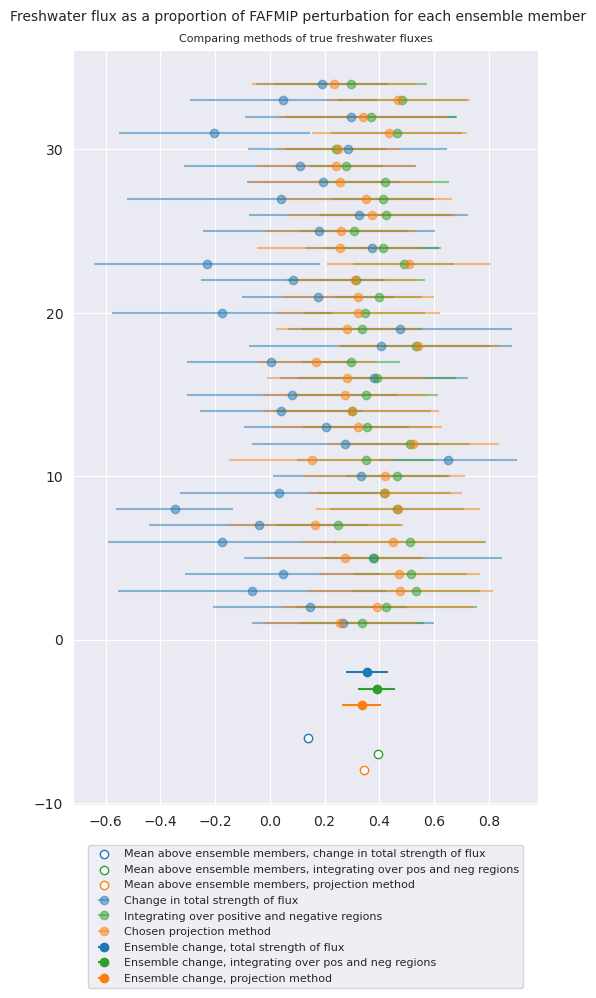

In [32]:
import seaborn as sns
sns.set_style(style="darkgrid")
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

#plot the three methods (two from this notebook and the projeciton method chosen) for each ensemble member
fig,ax=plt.subplots(figsize=(6,10))
plt.errorbar(mean_boot_m1, np.linspace(1,34,34),xerr=std_boot_m1,fmt ='o',alpha=0.5,
        color='tab:blue',ms=6, label='Change in total strength of flux')
plt.errorbar(mean_boot_m2, np.linspace(1,34,34),xerr=std_boot_m2,fmt ='o',alpha=0.5,
        color='tab:green',ms=6, label='Integrating over positive and negative regions')
plt.errorbar(mean_boot, np.linspace(1,34,34),xerr=std_boot,fmt ='o',alpha=0.5,
        color='tab:orange',ms=6, label='Chosen projection method')


#plot the three methods applied to ensemble mean fluxes
plt.errorbar(change1.mean(),-2,xerr=change1.std(),fmt ='o',color='tab:blue',ms=6,label='Ensemble change, total strength of flux')
plt.errorbar(change2.mean(),-3,xerr=change2.std(),fmt ='o',color='tab:green',label='Ensemble change, integrating over pos and neg regions')
plt.errorbar(ensemble_projection_mean_std[0],-4,xerr=ensemble_projection_mean_std[1],fmt ='o',color='tab:orange',label='Ensemble change, projection method')

#the mean of each method across ensemble members (i.e mean of dots above)
ax.scatter(np.average(mean_boot_m1,weights=std_boot_m1),-6,color='white',edgecolors='tab:blue', label='Mean above ensemble members, change in total strength of flux')
ax.scatter(np.average(mean_boot_m2,weights=std_boot_m2),-7,color='white',edgecolors='tab:green',label='Mean above ensemble members, integrating over pos and neg regions')
ax.scatter(np.average(mean_boot,weights=std_boot),-8,color='white',edgecolors='tab:orange',label='Mean above ensemble members, projection method')


plt.title('Comparing methods of true freshwater fluxes',fontsize=8)
plt.suptitle('Freshwater flux as a proportion of FAFMIP perturbation for each ensemble member',fontsize=10, y=0.92)
ax.legend(loc='lower center',bbox_to_anchor=(0.5,-0.25),fontsize=8)